In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import des librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from imblearn.metrics import classification_report_imbalanced

In [3]:
# Import DataFrame pour modélisation
df = pd.read_csv('/content/df_model.csv', index_col=0)

# La saison lue en tant que numérique est remise en chaine de caractère
df['Saison'] = df['Saison'].astype(str)
df_tot=df.copy()

# Sélection des variables

In [4]:
# Variables sélectionnées pour la modélisation
xvars = ['Saison','Min_cote_domicile','Min_cote_exterieur','note_def_ext','note_gen_dom','Points_moy_match_saison_dom','Moy_buts_5_matchs_dom',
           'Points_moy_match_saison_ext']

df = df.loc[:, xvars + ["Resultat_match"]]
df['Resultat_match'] = df['Resultat_match'].replace(['H','D','A'], [2, 1,0])

In [ ]:
# Création des dataframes de cible et de données
target = df[['Resultat_match','Saison']]
data = df.loc[:, xvars]

# Remplacement des modalités de target par des nombres pour la modélisation
target['Resultat_match'] = target['Resultat_match'].replace(['H','D','A'], [2, 1,0])

# Création des dataframe d'entrainement et de test : entrainement sur les saisons 2015 à 2020 et test sur 2021 (saison non encore terminée)
X_train_=data.loc[data['Saison'] != '2021', :].drop('Saison',axis=1)
X_test_=data.loc[data['Saison'] == '2021', :].drop('Saison',axis=1)
y_train=target.loc[target['Saison'] != '2021', :].drop('Saison',axis=1)
y_test=target.loc[target['Saison'] == '2021', :].drop('Saison',axis=1)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

y_test=y_test.to_numpy().reshape(220,)
y_train=y_train.to_numpy().reshape(2178,)

# Modèle (KNN)

In [6]:
# On reprend notre modèle KNN
knn = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors= 55, weights= 'uniform')
cv = KFold(n_splits=3, random_state=22 , shuffle = True)

scores = cross_validate(knn, X_train, y_train, cv=cv, scoring=['accuracy','f1_micro', 'f1_macro', 'f1_weighted'])
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
confusion_matrix=pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par random forest'])

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));

Accuracy:  0.5181818181818182


Etude de l'importance des variables conservées avec un modèle Lasso

In [7]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X_train_.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.011075
Best score using built-in LassoCV: 0.151842
Lasso picked 6 variables and eliminated the other 1 variables


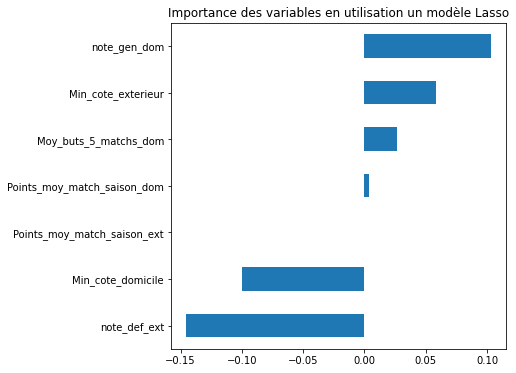

In [8]:
fig = plt.figure(figsize=(6,6))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importance des variables en utilisation un modèle Lasso")
fig.savefig('importance_graph.png', dpi=200, bbox_inches = 'tight') ;

La variable Points_moy_match_saison_ext n'a pas l'air d'avoir d'impact mais après un test sur le KNN sans cette variable, le résultat était moins bon. De même en enlevant la variables Points_moy_match_saison_dom qui, pour ce modèle, a peu d'importance.
Ce graphique nous indique que plus la note générale de l'équipe à domicile est élevée, plus cette équipe a de chance de gagner (résultat 2). Au contraire, plus la note de l'équipe extérieur a une note de défense élevée, plus le résultat a de chance d'être une victoire de l'équipe à l'extérieur (résultat 0).
De même, plus la cote des bookmakers pour l'équipe extérieur est élevée, plus l'équipe à domicile a une chance de gagner. Le contraire est valable avec le minimum de la cote à domicile qui a un effet négatif sur la chance de victoire de l'équipe à domicile.

Installation du package shap

In [ ]:
pip install shap

Summary plot

In [10]:
import shap
#X_train=pd.DataFrame(X_train,columns=X_train_.columns)
X_test_df=pd.DataFrame(X_test,columns=X_train_.columns)

# Création des valeurs SHAP
knn_explainer = shap.KernelExplainer(knn.predict,X_test_df)
knn_shap_values = knn_explainer.shap_values(X_test_df)

Using 220 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/220 [00:00<?, ?it/s]

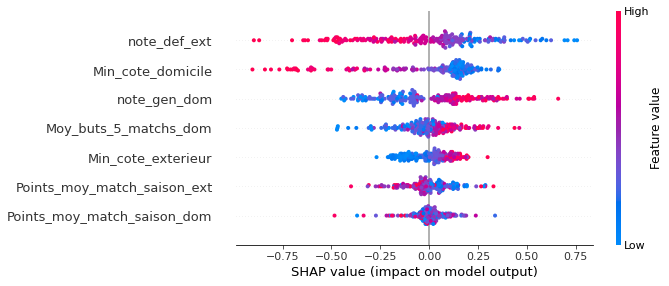

In [11]:
fig = plt.figure(figsize=(12,8))
shap.summary_plot(knn_shap_values, X_test_df)
fig.savefig('summary_plot.png', dpi=200, bbox_inches = 'tight') ;

Dans ce graphique, les variables sont aussi triées par ordre décroissant d'importance. Là encore, plus les valeurs de la note défensive de l'équipe extérieure sont élevées (rouge), plus le résultat attendu est 0 (victoire de l'équipe extérieure) car c'est du côté négatif de l'axe que nous les trouvons. Au contraire, on retrouve des points rouges sur le côté positif de l'axe pour la note générale de l'équipe à domicile.
Les 5 premières variables séparent bien les faibles et hautes valeurs, avec un effet négatif (plus de chance de perdre pour l'équipe à domicile) pour la note de défense de l'équipe extérieur et le minimum de la cote domicile et avec un effet positif (plus de chance de gagner pour l'équipe à domicile) pour les variables note générale à domicile, moyenne de buts sur 5 matchs à domicile et minimum de la cote de l'équipe extérieure.
Les 2 variables restantes séparent moins bien les hautes et faibles valeurs sur l'axe même si on devine un effet négatif pour les points moyens par match sur la saison pour l'équipe extérieure.
Tous ces résultats sont logiques par rapport à ce que nous pouvions attendre.

<Figure size 864x576 with 0 Axes>

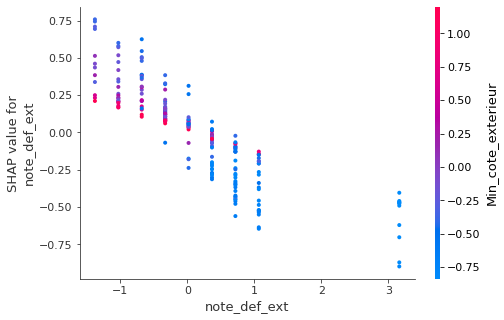

In [16]:
# plot de la valeur SHAP pour note_def_ext
fig = plt.figure(figsize=(12,8))
shap.dependence_plot("note_def_ext", knn_shap_values, X_test_df, interaction_index= "Min_cote_exterieur",show=False)
plt.savefig('shap_dependance_1.png', dpi=300, bbox_inches='tight');

On remarque une tendance linéaire négative marquée entre la note défensive de l'équipe extérieur et le résultat. Le minimum de la cote de l'équipe à l'extérieur baisse quand la note défensive augmente.

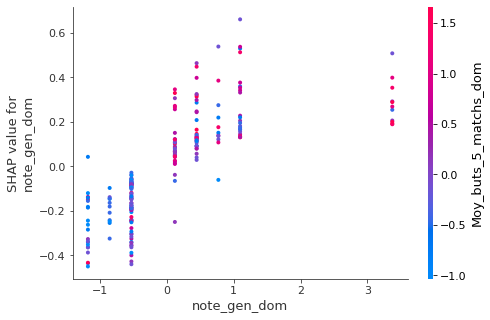

In [13]:
shap.dependence_plot("note_gen_dom", knn_shap_values, X_test_df, interaction_index= "Moy_buts_5_matchs_dom",show=False)
plt.savefig('shap_dependance_2.png', dpi=200, bbox_inches='tight')

On remarque une tendance linéaire positive entre la note générale de l'équipe à domicile et le résultat. Il n'y a pas d'interaction marquée entre cette variable et la moyenne des buts sur 5 matchs.

Niveau local sur un match

<Figure size 1800x432 with 0 Axes>

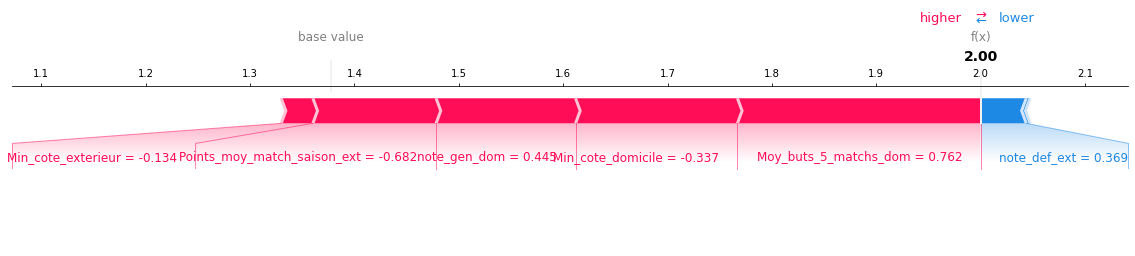

In [14]:
shap.initjs()
fig = plt.figure(figsize=(25,6))
# A faire varier
num_match_test = 3

shap.force_plot(knn_explainer.expected_value,knn_shap_values[num_match_test,:], X_test_df.iloc[num_match_test,:].round(3), matplotlib=True,show=False)
plt.savefig('shap_local_graph.png', dpi=300, bbox_inches='tight')

Pour le 4ème match de la saison 2021 (Rennes-Lens), la prévision est une victoire à domicile. Les variables qui entrainent cette prédiction haute sont les variables en rouge, en particulier la moyenne de buts sur 5 matchs à domicile, alors que la note défensive de l'équipe adverse à l'effet de faire diminuer cette probabilité.

<Figure size 1800x432 with 0 Axes>

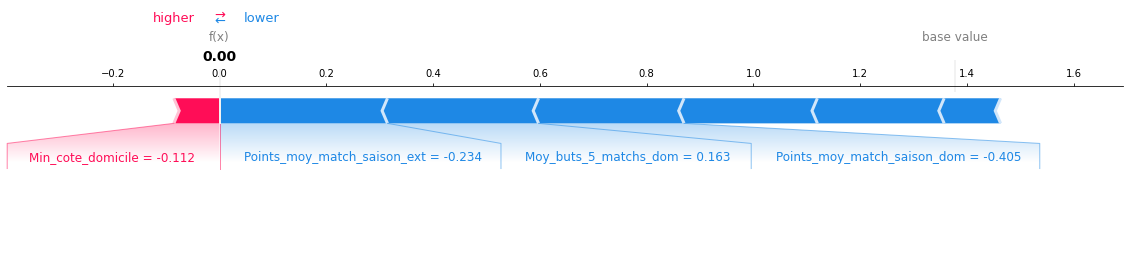

In [23]:
fig = plt.figure(figsize=(25,6))
num_match_test = 80
shap.force_plot(knn_explainer.expected_value,knn_shap_values[num_match_test,:], X_test_df.iloc[num_match_test,:].round(3), matplotlib=True,show=False)
plt.savefig('shap_local_graph_80.png', dpi=300, bbox_inches='tight')

Pour le match Montpellier - Strasbourg, la prévision est une victoire à l'extérieur de Strasbourg, est portée par toutes les variables sauf la cote à domicile qui était en faveur d'une victoire de Montpellier. Le résultat du match a été un match nul (mauvaise prévision des bookmakers et de notre modèle).